In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_style('whitegrid')

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)

from MyTools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
PATH = "../"

In [12]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]
df = add_AR_cols(df,7)

In [13]:
y = df['Box']
X = df.drop(['Box', 'Neutral_SENTIMENT', 'Bull-Bear Spread_SENTIMENT'], axis=1)

prepocessing_pipeline = make_pipeline(SelectKBest(k=40), StandardScaler(), MinMaxScaler(feature_range=(-1,1)))

In [14]:
X = prepocessing_pipeline.fit_transform(X,y)

cols = prepocessing_pipeline.named_steps['selectkbest'].get_feature_names_out()

X = pd.DataFrame(data=X, columns=cols)

In [15]:
coeffs_list =[]
c_s = np.geomspace(1,1e8,100)

lasso = LogisticRegression(C=1/c_s[0], fit_intercept=True, penalty='l1', solver='saga')
lasso.fit(X,y)
coeffs_list.append(lasso.coef_[0])

X =X [np.array(X.columns)[coeffs_list[0]!=0]]

tab_coeff = np.empty([len(c_s)-1,len(X.columns)])

c_s = c_s[1:]

for i in range(len(c_s)):
    lasso = LogisticRegression(C=1/c_s[i], fit_intercept=True, penalty='l1', solver='liblinear')
    lasso.fit(X,y)
    tab_coeff[i,:]= lasso.coef_[0]

In [16]:
coeff_df = pd.DataFrame(data=tab_coeff[::-1], index=c_s[::-1], columns=X.columns)
coeff_df["Valid cols"] = coeff_df[coeff_df!=0].count(axis=1)

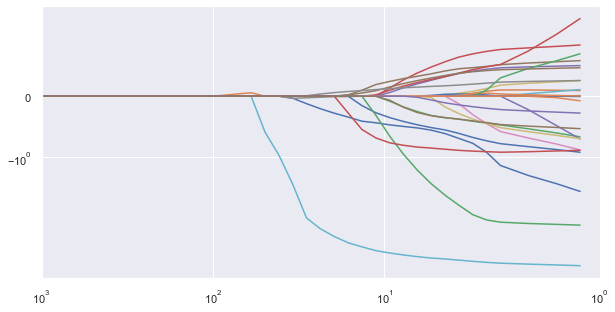

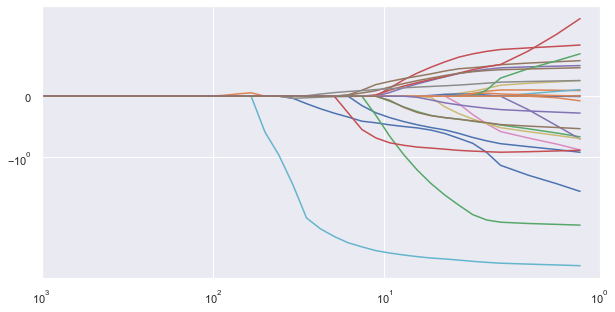

In [17]:
plot = coeff_df.drop("Valid cols", axis=1).plot(legend= False, logx='sym', logy='sym',xlim = [1e3, 1])
plt.show()

In [43]:
first_cols = coeff_df[coeff_df['Valid cols']==9][coeff_df!=0].dropna(axis=1).columns

plot = coeff_df[first_cols].drop("Valid cols", axis=1)
plt.show()

In [44]:
plot


,PX_OPEN_VIX_volatility,TOT_OPT_VOLUME_CUR_DAY_SPX_volatility,QMJ USA_QMJ Factors,PX_HIGH_CL3,Bullish 8-week Mov Avg_SENTIMENT,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,VIX_LAG_1,VIX_LAG_3
1.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8.302176e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6.892612e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5.722368e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.750810e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2.535364e+00,-0.919282,0.486780,0.479971,0.419217,0.212813,-5.002320,-0.730098,-2.061227,-0.907927
2.104904e+00,-1.129783,0.514547,0.517406,0.432396,0.229542,-5.092223,-0.776485,-2.160173,-0.916284
1.747528e+00,-1.292196,0.541194,0.738241,0.445058,0.240264,-5.189875,-0.825366,-2.219808,-0.907894
1.450829e+00,-1.430935,0.563287,1.012115,0.455924,0.248784,-5.282386,-0.872982,-2.260613,-0.895384


In [45]:
print(len(first_cols))

import plotly.express as px
fig = px.line(plot, x=plot.index, y=plot.columns,range_x=[1e2, 1], log_x=True)
with open("analysis/lasso_selection_graph_g0b.html", "w") as f:
    f.write(fig.to_html())


10
